In [186]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from collections import Counter
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.interpolate import interp1d
from sklearn.utils import resample
from scipy.stats import wilcoxon
import math
import matplotlib.cm as cm
from functools import reduce

## Load and explore the bile acid data 

In [189]:
#Read the file 

bile_acid = pd.read_csv("Bile acid metabolomics.csv")

In [191]:
bile_acid.describe()

,5-Cholenic Acid-3-beta-ol,3-Ketocholanic Acid,Isolithocholic Acid,Isoallolithocholic Acid,5-beta-Cholenic Acid-7-alpha-ol-3-one,5-alpha-Cholanic Acid-3-alpha-ol-6-one,3-alpha-Hydroxy-7 Ketolithocholic Acid,3-alpha-Hydroxy-12 Ketolithocholic Acid,Murocholic Acid,"5-beta-Cholanic Acid-3-beta, 12-alpha-diol",...,Tauroursodeoxycholic Acid-3-Sulfate,Glycoursodeoxycholic Acid-3-Sulfate,23-Norcholic Acid,6-Oxolithocholic Acid,5-beta-Cholanic Acid 12-alpha-ol-3-one,5-alpha-Cholanic Acid-3-one,Lithocholic Acid,"3,7-Diketocholanic Acid|3,6-Diketocholanic Acid|3,12-Diketocholanic Acid",12-Ketochenodeoxycholic acid|7-Ketodeoxycholic acid,Cholic acid|Ursocholic acid
count,5.800000e+01,5.800000e+01,5.800000e+01,5.800000e+01,5.800000e+01,58.000000,5.800000e+01,5.800000e+01,5.800000e+01,5.800000e+01,...,5.800000e+01,5.800000e+01,58.000000,5.800000e+01,5.800000e+01,58.000000,5.800000e+01,58.000000,5.800000e+01,5.800000e+01
mean,1.544409e+05,3.457407e+05,2.467994e+06,1.375877e+05,6.949283e+04,69022.786208,4.602162e+06,7.890190e+05,1.378433e+06,2.864686e+06,...,1.770156e+05,9.741374e+06,46279.551218,5.537701e+04,3.735725e+05,9042.452186,1.142615e+07,31282.748468,9.081918e+06,4.345164e+07
std,2.473163e+05,8.856513e+05,5.756439e+06,5.548393e+05,1.668629e+05,73368.887409,1.022718e+07,1.807107e+06,3.037953e+06,6.469065e+06,...,5.679351e+05,2.563355e+07,38740.205032,1.833347e+05,8.651290e+05,26631.804591,2.447550e+07,63389.180840,1.575247e+07,5.566288e+07
min,8.892579e+02,6.411174e+02,8.107466e+02,3.351499e+02,8.152327e+02,1585.163904,8.600671e+03,5.367280e+02,8.785149e+03,1.105063e+03,...,1.336720e+03,3.136491e+03,2124.716673,3.952590e+02,4.540381e+02,245.572952,7.125325e+03,889.076980,6.596234e+03,3.863005e+04
25%,2.949559e+04,1.902613e+03,3.598644e+03,1.069335e+03,5.943228e+03,14861.962011,9.673621e+04,3.685460e+03,1.633542e+04,4.721275e+03,...,2.385101e+03,1.735748e+04,10554.093958,9.318735e+02,2.471878e+03,616.627742,3.791535e+04,3329.779014,1.281978e+05,2.450131e+06
50%,6.127628e+04,3.870275e+03,1.356858e+04,2.192392e+03,2.106428e+04,43902.187923,6.624553e+05,1.287377e+04,9.447104e+04,1.536695e+04,...,4.707784e+03,8.609316e+04,33304.501576,4.838407e+03,9.446025e+03,1063.842764,1.115353e+05,7354.453929,1.529397e+06,2.057610e+07
75%,1.721597e+05,1.462081e+05,1.378461e+06,1.746036e+04,7.152543e+04,94048.582823,4.307931e+06,2.784623e+05,1.358408e+06,1.269590e+06,...,2.491390e+04,1.065515e+06,74045.790741,2.105082e+04,1.316188e+05,5876.448199,5.096436e+06,22471.669584,1.128196e+07,6.653630e+07
max,1.443494e+06,4.790872e+06,2.597288e+07,2.984533e+06,1.226246e+06,291525.543607,6.790660e+07,7.286673e+06,1.592482e+07,2.812569e+07,...,3.388543e+06,1.120971e+08,129853.183210,1.302494e+06,3.533295e+06,166807.347919,1.011556e+08,367832.825346,6.905910e+07,2.175443e+08


In [193]:
bile_acid.shape

(58, 50)

In [195]:
# Map the sample ID to the time point 

timepoint_map = {
    'A': 'Baseline',
    'B': 'Week 2',
    'C': 'Week 4',
    'D': 'Week 8'
}

bile_acid['Timepoint'] = bile_acid['SampleID'].str[-1].map(timepoint_map)


In [197]:
bile_acid.head(58)

,SampleID,5-Cholenic Acid-3-beta-ol,3-Ketocholanic Acid,Isolithocholic Acid,Isoallolithocholic Acid,5-beta-Cholenic Acid-7-alpha-ol-3-one,5-alpha-Cholanic Acid-3-alpha-ol-6-one,3-alpha-Hydroxy-7 Ketolithocholic Acid,3-alpha-Hydroxy-12 Ketolithocholic Acid,Murocholic Acid,...,Glycoursodeoxycholic Acid-3-Sulfate,23-Norcholic Acid,6-Oxolithocholic Acid,5-beta-Cholanic Acid 12-alpha-ol-3-one,5-alpha-Cholanic Acid-3-one,Lithocholic Acid,"3,7-Diketocholanic Acid|3,6-Diketocholanic Acid|3,12-Diketocholanic Acid",12-Ketochenodeoxycholic acid|7-Ketodeoxycholic acid,Cholic acid|Ursocholic acid,Timepoint
0,1A,2.471480e+04,2.486340e+06,1.726029e+07,2.968300e+06,1.350017e+04,55246.013253,5.033034e+04,3.237215e+06,7.536789e+04,...,7.487345e+03,129853.183210,5.731376e+04,1.655114e+06,166807.347919,5.438780e+07,164840.479466,2.947933e+04,5.305731e+04,Baseline
1,2A,3.593117e+04,3.161716e+03,2.959778e+03,9.841400e+02,1.634303e+04,4645.240663,5.985989e+05,7.118947e+04,1.301774e+06,...,4.370474e+04,2428.956674,4.483908e+03,2.178728e+04,592.326550,2.138802e+05,3784.990371,3.835766e+05,2.508685e+06,Baseline
2,3A,2.126369e+04,5.998576e+05,5.876149e+06,1.537954e+04,2.534402e+04,19286.796552,3.429604e+05,5.449764e+06,1.377286e+06,...,3.136491e+03,41415.526403,1.987788e+04,3.080819e+06,7295.708362,7.446428e+07,66744.234930,1.385989e+05,3.291237e+06,Baseline
3,4A,3.308911e+04,4.790872e+06,2.597288e+07,2.984533e+06,8.859639e+03,35022.701022,6.453529e+04,7.286673e+06,9.491215e+04,...,4.570927e+03,117671.532755,7.076619e+04,2.343040e+06,114274.397091,1.011556e+08,367832.825346,4.632583e+04,3.323280e+05,Baseline
4,5A,2.782311e+04,8.383866e+05,4.820237e+06,1.997520e+05,3.092408e+04,21324.930390,6.606840e+05,8.319890e+05,5.269916e+05,...,2.026247e+05,9982.564293,2.309528e+04,1.810345e+05,9143.064369,3.614314e+07,21219.132878,2.468609e+05,2.869606e+06,Baseline
5,6A,1.659311e+05,2.618862e+03,1.435778e+04,7.357662e+02,4.332300e+04,64520.558408,5.333389e+04,5.898122e+03,9.402993e+04,...,6.691886e+04,23877.651297,1.246058e+03,8.097789e+03,2682.676814,3.351469e+04,3973.716430,1.614899e+05,4.008678e+07,Baseline
6,7A,3.058692e+05,3.671383e+05,1.099234e+06,5.654775e+03,2.805119e+04,35303.847432,7.350935e+05,6.988815e+05,1.658409e+06,...,3.631813e+06,32438.821576,2.270560e+05,2.290330e+05,2575.908404,2.692093e+07,13223.830764,1.845758e+05,3.626909e+06,Baseline
7,8A,9.519115e+03,1.531703e+06,9.277376e+06,2.846933e+05,4.216444e+03,54743.297937,4.737691e+04,4.687839e+06,2.794621e+05,...,3.780303e+03,69006.566201,1.923893e+05,1.707155e+06,13121.320664,5.416240e+07,99340.500889,1.827741e+04,9.877883e+04,Baseline
8,9A,2.664540e+04,3.984953e+05,1.817083e+06,1.734768e+04,5.160484e+03,4302.089486,4.599272e+04,4.241623e+04,1.773260e+04,...,5.204695e+03,5058.716848,8.982971e+03,1.605208e+04,16148.224053,1.067126e+07,4365.352822,2.692013e+04,5.105027e+05,Baseline
9,10A,1.645170e+04,4.059009e+03,2.469560e+04,3.506138e+03,1.384424e+03,8053.659854,8.274418e+04,5.771203e+04,1.904849e+04,...,3.577969e+03,4753.067114,1.847351e+04,1.079426e+04,245.572952,2.896722e+05,2424.220636,2.162612e+05,1.534353e+06,Baseline


In [200]:
#Filter Data according to timepoints

filtered_b2 = bile_acid[bile_acid['Timepoint'].isin(['Baseline', 'Week 2'])]
filtered_b4 = bile_acid[bile_acid['Timepoint'].isin(['Baseline', 'Week 4'])]
filtered_b8 = bile_acid[bile_acid['Timepoint'].isin(['Baseline', 'Week 8'])]
# Display the result
filtered_b4.head(30)

,SampleID,5-Cholenic Acid-3-beta-ol,3-Ketocholanic Acid,Isolithocholic Acid,Isoallolithocholic Acid,5-beta-Cholenic Acid-7-alpha-ol-3-one,5-alpha-Cholanic Acid-3-alpha-ol-6-one,3-alpha-Hydroxy-7 Ketolithocholic Acid,3-alpha-Hydroxy-12 Ketolithocholic Acid,Murocholic Acid,...,Glycoursodeoxycholic Acid-3-Sulfate,23-Norcholic Acid,6-Oxolithocholic Acid,5-beta-Cholanic Acid 12-alpha-ol-3-one,5-alpha-Cholanic Acid-3-one,Lithocholic Acid,"3,7-Diketocholanic Acid|3,6-Diketocholanic Acid|3,12-Diketocholanic Acid",12-Ketochenodeoxycholic acid|7-Ketodeoxycholic acid,Cholic acid|Ursocholic acid,Timepoint
0,1A,24714.802286,2.486340e+06,1.726029e+07,2.968300e+06,1.350017e+04,55246.013253,5.033034e+04,3.237215e+06,7.536789e+04,...,7.487345e+03,129853.183210,57313.762280,1.655114e+06,166807.347919,5.438780e+07,164840.479466,2.947933e+04,5.305731e+04,Baseline
1,2A,35931.172968,3.161716e+03,2.959778e+03,9.841400e+02,1.634303e+04,4645.240663,5.985989e+05,7.118947e+04,1.301774e+06,...,4.370474e+04,2428.956674,4483.908266,2.178728e+04,592.326550,2.138802e+05,3784.990371,3.835766e+05,2.508685e+06,Baseline
2,3A,21263.685502,5.998576e+05,5.876149e+06,1.537954e+04,2.534402e+04,19286.796552,3.429604e+05,5.449764e+06,1.377286e+06,...,3.136491e+03,41415.526403,19877.876282,3.080819e+06,7295.708362,7.446428e+07,66744.234930,1.385989e+05,3.291237e+06,Baseline
3,4A,33089.107070,4.790872e+06,2.597288e+07,2.984533e+06,8.859639e+03,35022.701022,6.453529e+04,7.286673e+06,9.491215e+04,...,4.570927e+03,117671.532755,70766.191603,2.343040e+06,114274.397091,1.011556e+08,367832.825346,4.632583e+04,3.323280e+05,Baseline
4,5A,27823.105661,8.383866e+05,4.820237e+06,1.997520e+05,3.092408e+04,21324.930390,6.606840e+05,8.319890e+05,5.269916e+05,...,2.026247e+05,9982.564293,23095.277602,1.810345e+05,9143.064369,3.614314e+07,21219.132878,2.468609e+05,2.869606e+06,Baseline
5,6A,165931.138815,2.618862e+03,1.435778e+04,7.357662e+02,4.332300e+04,64520.558408,5.333389e+04,5.898122e+03,9.402993e+04,...,6.691886e+04,23877.651297,1246.058091,8.097789e+03,2682.676814,3.351469e+04,3973.716430,1.614899e+05,4.008678e+07,Baseline
6,7A,305869.187593,3.671383e+05,1.099234e+06,5.654775e+03,2.805119e+04,35303.847432,7.350935e+05,6.988815e+05,1.658409e+06,...,3.631813e+06,32438.821576,227056.022529,2.290330e+05,2575.908404,2.692093e+07,13223.830764,1.845758e+05,3.626909e+06,Baseline
7,8A,9519.114985,1.531703e+06,9.277376e+06,2.846933e+05,4.216444e+03,54743.297937,4.737691e+04,4.687839e+06,2.794621e+05,...,3.780303e+03,69006.566201,192389.287265,1.707155e+06,13121.320664,5.416240e+07,99340.500889,1.827741e+04,9.877883e+04,Baseline
8,9A,26645.401460,3.984953e+05,1.817083e+06,1.734768e+04,5.160484e+03,4302.089486,4.599272e+04,4.241623e+04,1.773260e+04,...,5.204695e+03,5058.716848,8982.970901,1.605208e+04,16148.224053,1.067126e+07,4365.352822,2.692013e+04,5.105027e+05,Baseline
9,10A,16451.696848,4.059009e+03,2.469560e+04,3.506138e+03,1.384424e+03,8053.659854,8.274418e+04,5.771203e+04,1.904849e+04,...,3.577969e+03,4753.067114,18473.513032,1.079426e+04,245.572952,2.896722e+05,2424.220636,2.162612e+05,1.534353e+06,Baseline


In [202]:
# Remove 2A patient 

filtered_b4_clean = filtered_b4.drop(1).reset_index(drop=True)

In [204]:
filtered_b4_clean.shape

(28, 51)

In [206]:
filtered_b4_clean.head(30)

,SampleID,5-Cholenic Acid-3-beta-ol,3-Ketocholanic Acid,Isolithocholic Acid,Isoallolithocholic Acid,5-beta-Cholenic Acid-7-alpha-ol-3-one,5-alpha-Cholanic Acid-3-alpha-ol-6-one,3-alpha-Hydroxy-7 Ketolithocholic Acid,3-alpha-Hydroxy-12 Ketolithocholic Acid,Murocholic Acid,...,Glycoursodeoxycholic Acid-3-Sulfate,23-Norcholic Acid,6-Oxolithocholic Acid,5-beta-Cholanic Acid 12-alpha-ol-3-one,5-alpha-Cholanic Acid-3-one,Lithocholic Acid,"3,7-Diketocholanic Acid|3,6-Diketocholanic Acid|3,12-Diketocholanic Acid",12-Ketochenodeoxycholic acid|7-Ketodeoxycholic acid,Cholic acid|Ursocholic acid,Timepoint
0,1A,24714.802286,2.486340e+06,1.726029e+07,2.968300e+06,1.350017e+04,55246.013253,5.033034e+04,3.237215e+06,7.536789e+04,...,7.487345e+03,129853.183210,57313.762280,1.655114e+06,166807.347919,5.438780e+07,164840.479466,2.947933e+04,5.305731e+04,Baseline
1,3A,21263.685502,5.998576e+05,5.876149e+06,1.537954e+04,2.534402e+04,19286.796552,3.429604e+05,5.449764e+06,1.377286e+06,...,3.136491e+03,41415.526403,19877.876282,3.080819e+06,7295.708362,7.446428e+07,66744.234930,1.385989e+05,3.291237e+06,Baseline
2,4A,33089.107070,4.790872e+06,2.597288e+07,2.984533e+06,8.859639e+03,35022.701022,6.453529e+04,7.286673e+06,9.491215e+04,...,4.570927e+03,117671.532755,70766.191603,2.343040e+06,114274.397091,1.011556e+08,367832.825346,4.632583e+04,3.323280e+05,Baseline
3,5A,27823.105661,8.383866e+05,4.820237e+06,1.997520e+05,3.092408e+04,21324.930390,6.606840e+05,8.319890e+05,5.269916e+05,...,2.026247e+05,9982.564293,23095.277602,1.810345e+05,9143.064369,3.614314e+07,21219.132878,2.468609e+05,2.869606e+06,Baseline
4,6A,165931.138815,2.618862e+03,1.435778e+04,7.357662e+02,4.332300e+04,64520.558408,5.333389e+04,5.898122e+03,9.402993e+04,...,6.691886e+04,23877.651297,1246.058091,8.097789e+03,2682.676814,3.351469e+04,3973.716430,1.614899e+05,4.008678e+07,Baseline
5,7A,305869.187593,3.671383e+05,1.099234e+06,5.654775e+03,2.805119e+04,35303.847432,7.350935e+05,6.988815e+05,1.658409e+06,...,3.631813e+06,32438.821576,227056.022529,2.290330e+05,2575.908404,2.692093e+07,13223.830764,1.845758e+05,3.626909e+06,Baseline
6,8A,9519.114985,1.531703e+06,9.277376e+06,2.846933e+05,4.216444e+03,54743.297937,4.737691e+04,4.687839e+06,2.794621e+05,...,3.780303e+03,69006.566201,192389.287265,1.707155e+06,13121.320664,5.416240e+07,99340.500889,1.827741e+04,9.877883e+04,Baseline
7,9A,26645.401460,3.984953e+05,1.817083e+06,1.734768e+04,5.160484e+03,4302.089486,4.599272e+04,4.241623e+04,1.773260e+04,...,5.204695e+03,5058.716848,8982.970901,1.605208e+04,16148.224053,1.067126e+07,4365.352822,2.692013e+04,5.105027e+05,Baseline
8,10A,16451.696848,4.059009e+03,2.469560e+04,3.506138e+03,1.384424e+03,8053.659854,8.274418e+04,5.771203e+04,1.904849e+04,...,3.577969e+03,4753.067114,18473.513032,1.079426e+04,245.572952,2.896722e+05,2424.220636,2.162612e+05,1.534353e+06,Baseline
9,11A,30348.053385,4.558111e+05,4.683340e+06,2.242861e+04,1.755317e+03,2684.125159,1.958641e+04,1.482571e+05,1.254788e+05,...,8.449155e+04,6043.677026,202543.788707,3.695961e+04,1710.910393,2.113750e+07,5040.954890,7.947851e+03,5.326599e+04,Baseline


## PCA

In [210]:
# Normalize and Scale for PCA

#baseline vs week 2
y_2 = filtered_b2["Timepoint"]
x_2 = filtered_b2.drop(columns= ["Timepoint", "SampleID"])

#baseline vs week 4 
y_4 = filtered_b4["Timepoint"]
x_4 = filtered_b4.drop(columns= ["Timepoint", "SampleID"])

#baseline vs week 8

y_8 = filtered_b8["Timepoint"]
x_8 = filtered_b8.drop(columns= ["Timepoint", "SampleID"])

#all 

y = bile_acid['Timepoint']
x = bile_acid.drop(columns= ["Timepoint", "SampleID"])

In [212]:
# Log transform the xs

log_X2 = np.log1p(x_2)
log_X4 = np.log1p(x_4)
log_X8 = np.log1p(x_8)
log_X = np.log1p(x)

In [214]:
# Scale x 

scaler = StandardScaler()
X2_scaled = scaler.fit_transform(log_X2)
X4_scaled = scaler.fit_transform(log_X4)
X8_scaled = scaler.fit_transform(log_X8)
X_scaled = scaler.fit_transform(log_X)

In [216]:
log_X4.shape

(29, 49)

## PCA Baseline Vs. Week 2

In [219]:
#perfome PCA on logged data 

pca = PCA(n_components = 2)
pca_result2 = pca.fit_transform(X2_scaled)

In [221]:
# Helper function to draw ellipse
def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        scale_factor = np.sqrt(chi2.ppf(0.95, df=2))  # ~2.4477
        width, height = 2 * scale_factor * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    ellipse = Ellipse(xy=position, width = width, height = height, angle = angle, **kwargs)
    ax.add_patch(ellipse)

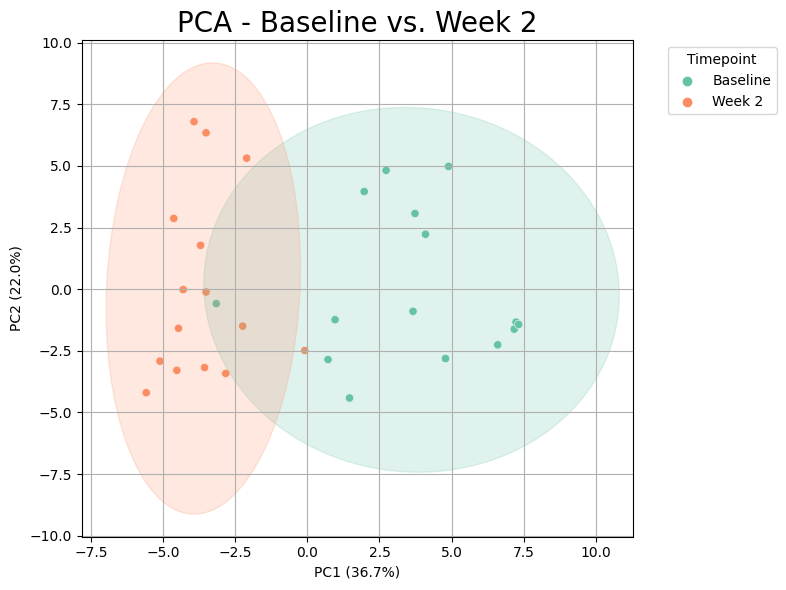

In [223]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_2 = pd.DataFrame(pca_result2[:, :2], columns=['PC1', 'PC2'], index=filtered_b2.index)

# Step 2: Add Timepoint metadata
pca_df_2['Timepoint'] = y_2

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_2, x='PC1', y='PC2', hue=y_2, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_2['Timepoint'].unique()):
    group = pca_df_2[pca_df_2['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("PCA - Baseline vs. Week 2", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('Bile_PCA_2.png')
plt.show()

## Baseline Vs Week 4 

In [226]:
#perfome PCA on logged data 

#pca = PCA(n_components = 2)
pca_result4 = pca.fit_transform(X4_scaled)

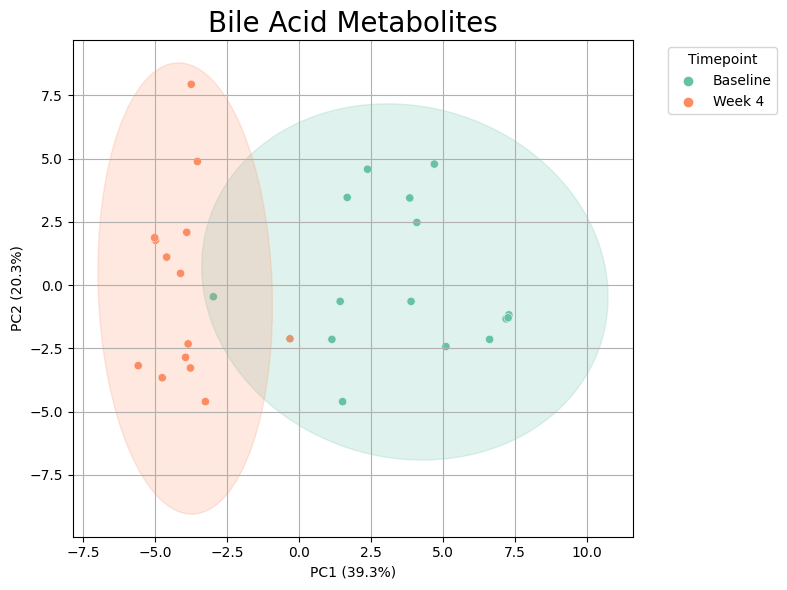

In [228]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_4 = pd.DataFrame(pca_result4[:, :2], columns=['PC1', 'PC2'], index=filtered_b4.index)

# Step 2: Add Timepoint metadata
pca_df_4['Timepoint'] = y_4

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_4, x='PC1', y='PC2', hue=y_4, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_4['Timepoint'].unique()):
    group = pca_df_4[pca_df_4['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("Bile Acid Metabolites", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('bile_PCA_4.png')
plt.show()

## Baseline Vs Week 8 

In [231]:
# Perform PCA baseline vs week 8 

pca_result8 = pca.fit_transform(X8_scaled)

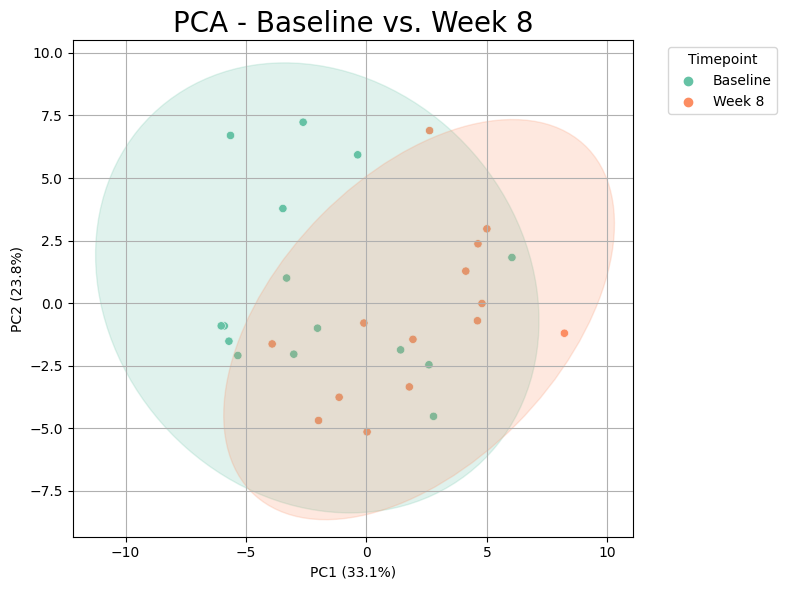

In [233]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_8 = pd.DataFrame(pca_result8[:, :2], columns=['PC1', 'PC2'], index=filtered_b8.index)

# Step 2: Add Timepoint metadata
pca_df_8['Timepoint'] = y_8

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_8, x='PC1', y='PC2', hue=y_8, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_8['Timepoint'].unique()):
    group = pca_df_8[pca_df_8['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("PCA - Baseline vs. Week 8", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('bile_PCA_8.png')
plt.show()

## All Timepoints 

In [236]:
# Perform PCA baseline vs week 8 

pca_result_all = pca.fit_transform(X_scaled)

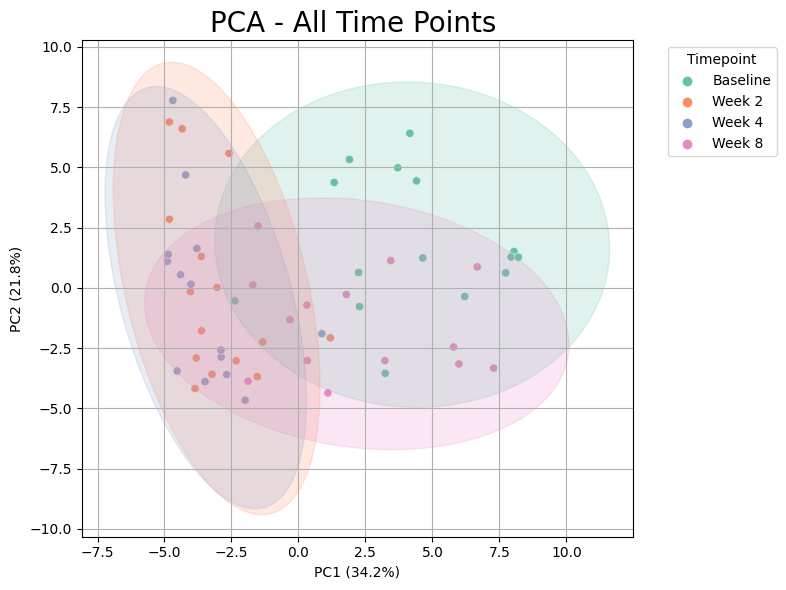

In [238]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_all = pd.DataFrame(pca_result_all[:, :2], columns=['PC1', 'PC2'], index=bile_acid.index)

# Step 2: Add Timepoint metadata
pca_df_all['Timepoint'] = bile_acid['Timepoint']

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_all, x='PC1', y='PC2', hue=y, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_all['Timepoint'].unique()):
    group = pca_df_all[pca_df_all['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("PCA - All Time Points ", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('bile_PCA_all.png')
plt.show()